# Poincaré Sections

`DoublePendulumSubclassMomenta` is a class refactor aiming to plot Poincaré sections

In [1]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
#from contourpy.util.data import simple

from MathFunctions import *
from DoublePendulumSubclassMomenta import DoublePendulum, DoublePendulumExplorer

----
&nbsp;
### Potential Energy Calculator

We need to find $E_{\text{mech}}$ of the system which is all potential energy when releasing the pendulums from rest

In [2]:
def calculate_potential_energy(theta1_val, theta2_val, parameters, model='simple'):
    """
    Calculate the potential energy of the double pendulum system relative to the datum where theta1 = 0 and theta2 = 0.
    
    Parameters:
    - theta1_val: The angle of the first pendulum (in radians).
    - theta2_val: The angle of the second pendulum (in radians).
    - parameters: A dictionary containing values for l1, l2, m1, m2, M1, M2, g.
    - model: The model type ('simple' or 'compound').
    
    Returns:
    - The relative potential energy V_relative (in Joules).
    """
    l1 = parameters['l1']
    l2 = parameters['l2']
    g = parameters['g']

    if model == 'simple':
        m1 = parameters['m1']
        m2 = parameters['m2']

        # Define potential energy function
        V = -(m1 + m2) * g * l1 * np.cos(theta1_val) - m2 * g * l2 * np.cos(theta2_val)

    elif model == 'compound':
        M1 = parameters['M1']
        M2 = parameters['M2']

        # Define potential energy function for compound model
        V = -M1 * g * (l1 / 2) * np.cos(theta1_val) - M2 * g * ((l1 * np.cos(theta1_val)) + (l2 / 2) * np.cos(theta2_val))
    
    else:
        raise ValueError("Model must be 'simple' or 'compound'")

    # Calculate potential energy at theta1 = 0 and theta2 = 0 (datum)
    V_zero = -(m1 + m2) * g * l1 - m2 * g * l2 if model == 'simple' else -M1 * g * (l1 / 2) - M2 * g * (l1 + (l2 / 2))

    # Calculate relative potential energy
    V_relative = V - V_zero

    return V_relative

In [3]:
parameters = {
    'l1': 1.0,  # Length of the first pendulum (meters)
    'l2': 1.0,  # Length of the second pendulum (meters)
    'm1': 1.0,  # Mass of the first pendulum (kg)
    'm2': 1.0,  # Mass of the second pendulum (kg)
    'M1': 1.0,  # Mass of the first pendulum (compound model)
    'M2': 1.0,  # Mass of the second pendulum (compound model)
    'g': 9.81  # Acceleration due to gravity (m/s^2)
}

angle1 = 0
angle2 = 180

theta1_val = np.deg2rad(angle1)  
theta2_val = np.deg2rad(angle2)  

In [4]:
# Calculate potential energy for the 'simple' model
V_simple = calculate_potential_energy(theta1_val, theta2_val, parameters, model='simple')
print(f"Potential Energy (Simple Model): {V_simple:.2f} J")

# Calculate potential energy for the 'compound' model
V_compound = calculate_potential_energy(theta1_val, theta2_val, parameters, model='compound')
print(f"Potential Energy (Compound Model): {V_compound:.2f} J")

Potential Energy (Simple Model): 19.62 J
Potential Energy (Compound Model): 9.81 J


----
&nbsp;
### `DoublePendulumExplorer` instantiation

In [5]:
l1, l2, m1, m2, M1, M2, g = sp.symbols('l1 l2 m1 m2 M1 M2 g', real=True, positive=True)

# Declare functions
theta1 = sp.Function('theta1')(t)
theta2 = sp.Function('theta2')(t)
p_theta_1 = sp.Function('p_theta_1')(t)
p_theta_2 = sp.Function('p_theta_2')(t)

In [6]:
# Parameters
params = {
    g: 9.81,  # Acceleration due to gravity (m/s^2)
    l1: 1.0,  # Length of the first rod (m)
    l2: 1.0,  # Length of the second rod (m)
    m1: 1.0,  # Mass of the first bob (kg)
    m2: 1.0,  # Mass of the second bob (kg)
    M1: 1.0,  # Mass of first uniform rod (kg)
    M2: 1.0   # Mass of second uniform rod (kg)
}

# Time vector

# calculate frames/second
# (time end - time start) * 200 = 24000 steps
# (time end - time start) * 400 = 48000 steps
# (time end - time start) * 800 = 96000 steps

stop = 120
fps = 400  # frames/second
no_steps = stop * fps

time = [0, stop, no_steps]

Increasing the time interval above 120 seconds does produce more Poincaré points but increases the noise

In [7]:
# Testing simple pendulum instantiation
# Initial conditions (theta1, theta2, omega1, omega2)

init_values = [0, 45, 0, 0]
pendulum1 = DoublePendulum(parameters=params, initial_conditions=init_values, time_vector=time)

In [8]:
# Instantiate DoublePendulumExplorer

simple_explorer = DoublePendulumExplorer(params, time, 'simple', 19.62)
compound_explorer = DoublePendulumExplorer(params, time, 'compound', 9.81)

DoublePendulumExplorer initialized with base class.
DoublePendulumExplorer initialized with base class.


----
&nbsp;
### The Poincaré Section

Check [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) documentation to tweak integrator arguments

In [9]:
# Define additional parameters for the numerical integration
integrator_args = {
    'rtol': 1e-6,    # default is 1e-3
    'atol': 1e-8     # default is 1e-6
    #'method': 'RK45',
}

With looser tolerances defined above, the solver introduces small errors at each step that accumulate over time, leading to points that are slightly off from their true positions. 

- Tighter tolerances hopefully reduce this drift at the expense of computational load. 

- We want an accurate representation of the system’s dynamics and we want it in a 'reasonable runtime`. These parameters are mutually exclusive

`n_jobs` parameter in the Parallel module of `_run_simulations()`

- **`n_jobs=-1`**: 
  - Use all available CPU cores.
  - Maximizes speed, but can fully load the CPU.

- **`n_jobs=None` or `n_jobs=1`**: 
  - Use a single core (no parallelism).

- **`n_jobs=X`** (where `X` is a positive integer): 
  - Use `X` CPU cores.
  - Balance between speed and resource usage.

- **`n_jobs=-2`**: 
  - Use all but one core.
  - Keeps one core free for other tasks.

- **`n_jobs=-X`** (where `X` > 1): 
  - Use all but `X` cores.
  - Leaves more cores free for other processes.

### `simple model`

In [10]:
simple_explorer.find_poincare_section(**integrator_args)

Batch 1 of 9 complete. Time taken: 21.32 seconds.
Batch 2 of 9 complete. Time taken: 18.60 seconds.
Batch 3 of 9 complete. Time taken: 17.04 seconds.
Batch 4 of 9 complete. Time taken: 16.04 seconds.
Batch 5 of 9 complete. Time taken: 14.23 seconds.
Batch 6 of 9 complete. Time taken: 15.15 seconds.
Batch 7 of 9 complete. Time taken: 15.66 seconds.
Batch 8 of 9 complete. Time taken: 17.09 seconds.
Batch 9 of 9 complete. Time taken: 16.29 seconds.
Simulations Complete. Time taken: 196.47 seconds.


In [11]:
def analyze_poincare_section_data(poincare_section_data):
    # Check if poincare_section_data is a list
    if not isinstance(poincare_section_data, list):
        print("poincare_section_data is not a list.")
        return
    
    # Check if poincare_section_data is a list of lists
    is_list_of_lists = all(isinstance(sublist, list) for sublist in poincare_section_data)
    if not is_list_of_lists:
        print("poincare_section_data is not a list of lists.")
        return
    
    # Print basic structure and statistics
    print(f"poincare_section_data contains {len(poincare_section_data)} sublists.")
    
    # Iterate over each sublist
    for i, sublist in enumerate(poincare_section_data):
        if sublist:
            print(f"Sublist {i}: contains {len(sublist)} points.")
            
            # Check if each point in the sublist is a tuple of two values
            is_tuple_of_two = all(isinstance(point, tuple) and len(point) == 2 for point in sublist)
            if not is_tuple_of_two:
                print(f"  Sublist {i} contains points that are not tuples of two values.")
                continue
            
            # Print min and max values for theta2 and p_theta_2 in this sublist
            theta2_values = [point[0] for point in sublist]
            p_theta_2_values = [point[1] for point in sublist]
            print(f"  Sublist {i}:")
            print(f"    theta2: min = {min(theta2_values):.4f}, max = {max(theta2_values):.4f}")
            print(f"    p_theta_2: min = {min(p_theta_2_values):.4f}, max = {max(p_theta_2_values):.4f}")
        else:
            print(f"Sublist {i}: is empty.")

In [12]:
#analyze_poincare_section_data(simple_explorer.poincare_section_data)

In [13]:
print(simple_explorer.initial_condition_data.shape)
print(type(simple_explorer.initial_condition_data))
print(len(simple_explorer.initial_condition_data[180]))
print(simple_explorer.initial_condition_data[180][:10])

(720, 48000, 4)
<class 'numpy.ndarray'>
48000
[[ 0.00000000e+00 -1.56861163e+00  0.00000000e+00  0.00000000e+00]
 [-3.37235565e-08 -1.56858097e+00  1.14420767e-09  2.45254513e-02]
 [-1.37712874e-07 -1.56848900e+00  9.02910674e-09  4.90508958e-02]
 [-3.20423592e-07 -1.56833571e+00  3.11925854e-08  7.35763261e-02]
 [-5.95948225e-07 -1.56812111e+00  7.71360359e-08  9.81017325e-02]
 [-9.84016304e-07 -1.56784519e+00  1.60866129e-07  1.22627101e-01]
 [-1.50999829e-06 -1.56750796e+00  3.04187044e-07  1.47152409e-01]
 [-2.20490122e-06 -1.56710941e+00  5.17882797e-07  1.71677647e-01]
 [-3.10536076e-06 -1.56664955e+00  8.19954560e-07  1.96202795e-01]
 [-4.25364087e-06 -1.56612837e+00  1.23788810e-06  2.20727829e-01]]


In [14]:
print(len(simple_explorer.poincare_section_data[360]))

218


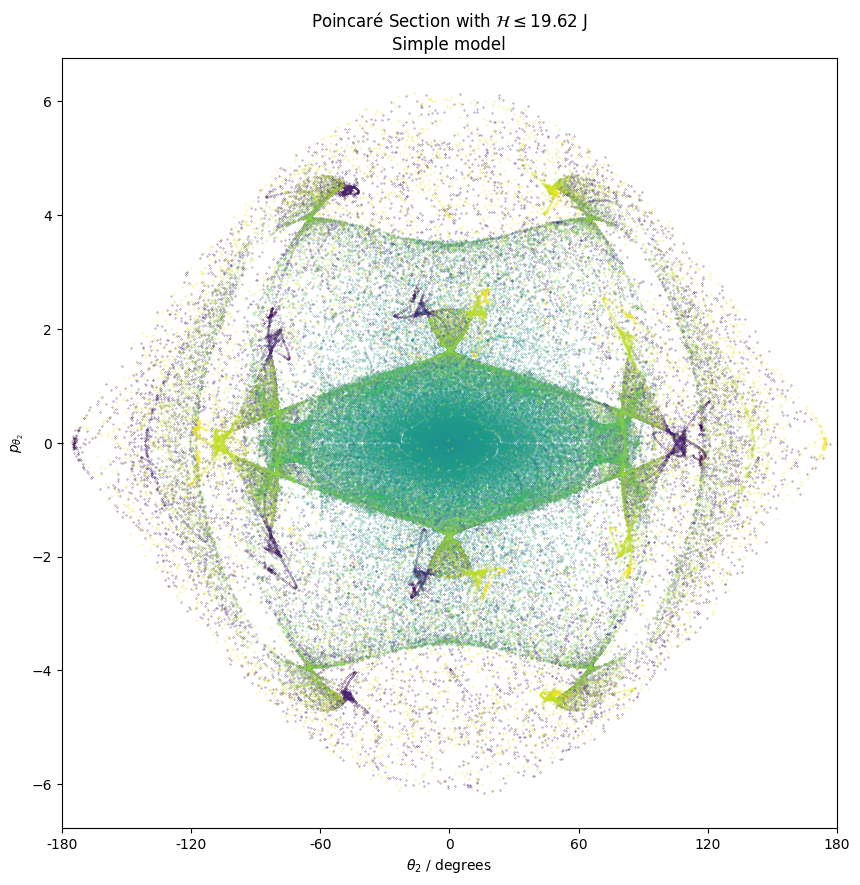

In [15]:
simple_explorer.plot_poincare_map()

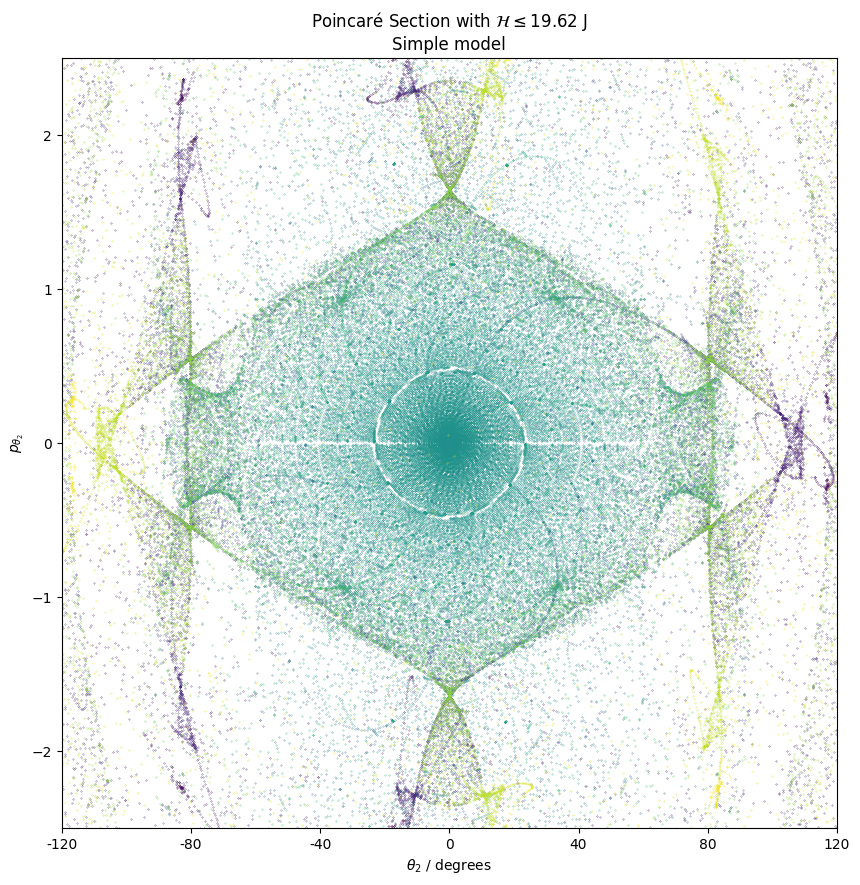

In [16]:
simple_explorer.plot_poincare_map(xrange=(-120*(np.pi/180), 120*(np.pi/180)), yrange=(-2.5, 2.5))

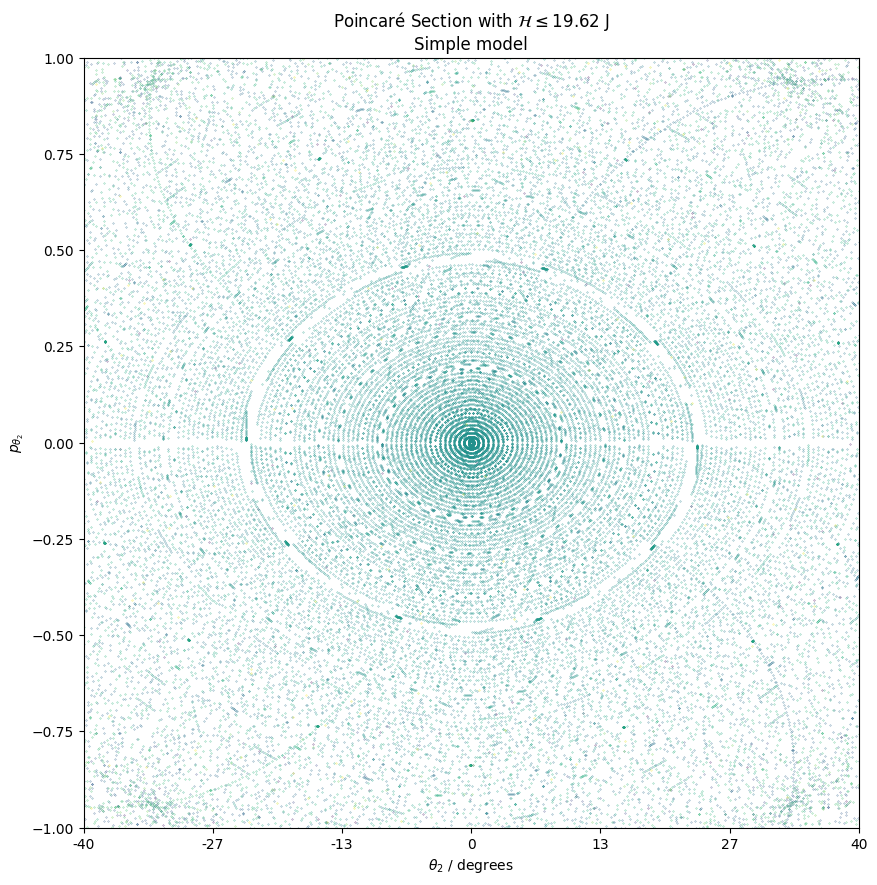

In [17]:
simple_explorer.plot_poincare_map(xrange=(-40*(np.pi/180), 40*(np.pi/180)), yrange=(-1, 1))

----
&nbsp;
### `compound model`

In [18]:
compound_explorer.find_poincare_section(**integrator_args)

Batch 1 of 9 complete. Time taken: 12.31 seconds.
Batch 2 of 9 complete. Time taken: 12.54 seconds.
Batch 3 of 9 complete. Time taken: 12.23 seconds.
Batch 4 of 9 complete. Time taken: 11.96 seconds.
Batch 5 of 9 complete. Time taken: 10.84 seconds.
Batch 6 of 9 complete. Time taken: 11.74 seconds.
Batch 7 of 9 complete. Time taken: 12.12 seconds.
Batch 8 of 9 complete. Time taken: 12.42 seconds.
Batch 9 of 9 complete. Time taken: 11.86 seconds.
Simulations Complete. Time taken: 153.08 seconds.


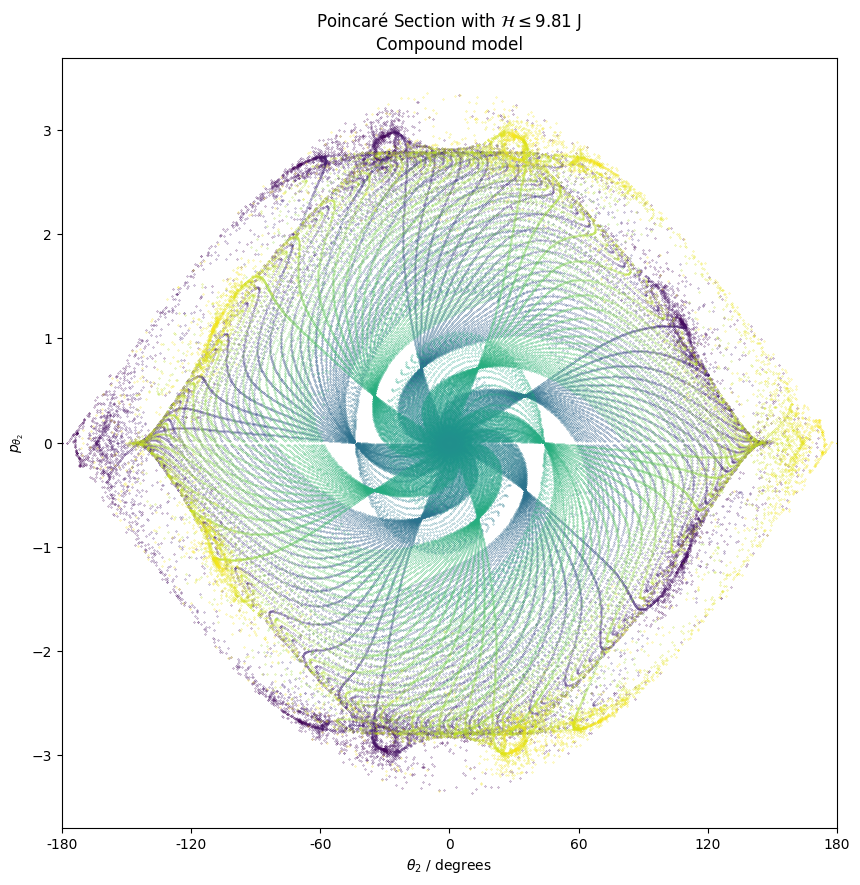

In [19]:
# special_angles_deg=[-90, -60, -30, 30, 60, 90]
compound_explorer.plot_poincare_map()

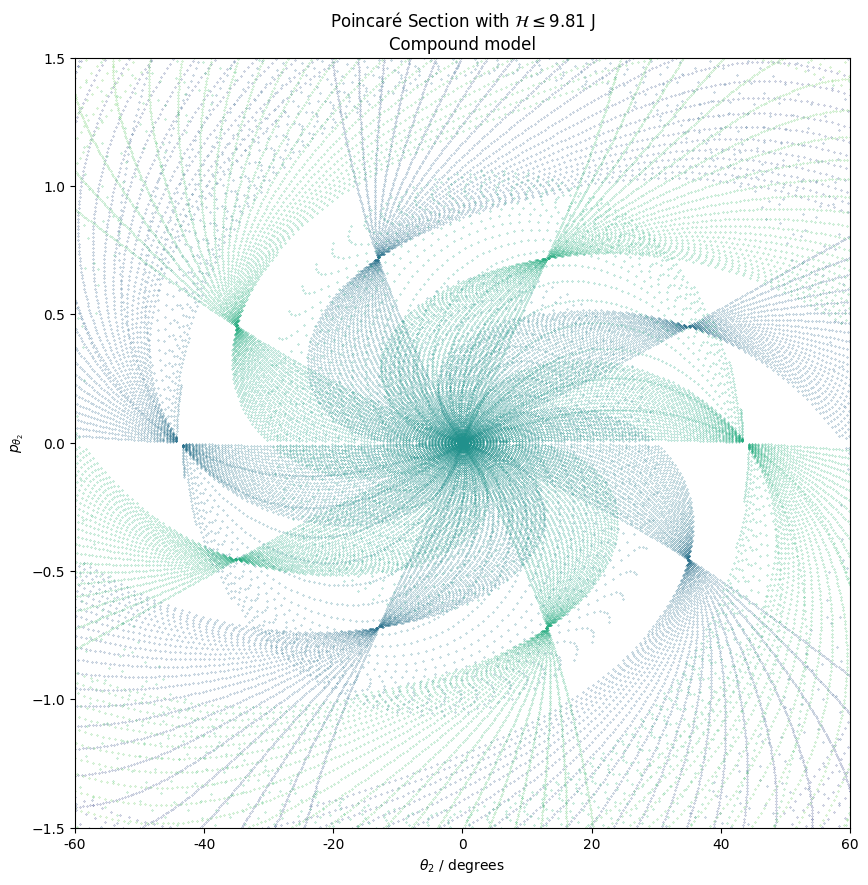

In [20]:
# special_angles_deg=[-90, -60, -30, 30, 60, 90]
compound_explorer.plot_poincare_map(xrange=(-60*(np.pi/180), 60*(np.pi/180)), yrange=(-1.5, 1.5))